We hereby declare that we have answered these exam questions ourselves without any outside help.

# Intro


## Outline / table of contents

## Imports, functions etc.

In [285]:
# imports
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import xarray as xr
import matplotlib.pyplot as plt

from scipy.stats import poisson
import seaborn as sns
from scipy.special import logit, expit
import warnings
warnings.filterwarnings('ignore')



In [238]:
#style
az.style.use("arviz-whitegrid")

In [249]:
#seed
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

## Helper Functions

In [240]:
def standardize_column(column):
    '''
    Transforms column by its z-score.
    '''
    standardized_column = (column - column.mean()) / column.std()
    
    return standardized_column

def transform_exp(x):
    '''
    Transform a value to its exponential value. 
    '''
    return np.exp(x)

## EDA

In [241]:
## load data
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   project       1127 non-null   object
 1   language      1127 non-null   object
 2   commits       1127 non-null   int64 
 3   insertions    1127 non-null   int64 
 4   age           1127 non-null   int64 
 5   bugs          1127 non-null   int64 
 6   project_type  1127 non-null   object
 7   devs          1127 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 70.6+ KB


#### Catagorical Feature exploration


In [242]:
df_cat = df.select_dtypes(include = ['O'])
for column in df_cat.columns:
  print('===========================')
  print(f'Column name: {column}')
  print('===========================')
  print(f'# of unique values: {len(df_cat[column].value_counts())}')
  print(f'# of average counts: {df_cat[column].value_counts().mean()}')
  print()

Column name: project
# of unique values: 729
# of average counts: 1.5459533607681757

Column name: language
# of unique values: 17
# of average counts: 66.29411764705883

Column name: project_type
# of unique values: 7
# of average counts: 161.0



In [243]:
# standardize columns
df['age_std'] = standardize_column(df['age'])
df['commits_std'] = standardize_column(df['commits'])
df['bugs_std'] = standardize_column(df['bugs'])

## factorize categorical
df["language"], languages = pd.factorize(df["language"])
df["project_type"], project_types = pd.factorize(df["project_type"])


# Analysis

## H1

### Poisson Regression

 **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L). 

We model the number of bugs with a poisson regression that includes an intercept for each language, thus getting the expected count of bugs for some language with the following model:
 $$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha_L \\
\alpha_L = \text{not yet determined} \\  $$
Where :
$$L \in \mathcal{L}, where \ \mathcal{L} = \{Python,Java..,C \} \\ |\mathcal{L}|=17 $$


### Prior Predictive Checks

Now what is a good choice of priors for $\alpha_L$?

* One thing we can we say for sure is that the number of counts cannot be negative but the question is how many bugs an average project might have? First of all, there need to be some software pushed to the project, which is denoted by the number of commits **C**. As soon as a project has one commit, there must also be some probability that there is some bug in that pushed code. Based on own work experience, the number commits depending on what type of project, can range from a few commits to a 100. Some projects in the dataset we believe are much bigger meaning they have many more commits. A naive liveable space for the expected number of bugs would be in the interval $\lambda_i \in [0, \infty)$. Given our own experience, say that our project has a 100 commits and we are terrible programmers, this project would have a 100 bugs, so this is still a very large upper bound for the number of bugs. A more reasonable expected number of bugs could be a $1000$. 

* This belief about $\lambda_i$ is aimed to be reflected in the choice of prior for $\alpha_L$ that is the average number of bugs for a project.
* Since the expected value of $\lambda$ has a logarithmic relationship  to $\alpha_L$, the choice of priors can lead to exploding number of bugs using a prior with high variance. Another common choice of prior distribution, the standard normal $N(0,1)$, could lead to negative samples, that are mapped to expected value of bugs around 0. This amount of bugs in a project might also seem to good to be true.

* We explore the logarthmic relationship between $\alpha_L$ and the number of bugs with the following candidate prior distributions for $\alpha_L$:
    * $\alpha_L \sim Exp(1)$
    * $\alpha_L \sim N(0,1)$
    * $\alpha_L \sim log \ N(0,1)$

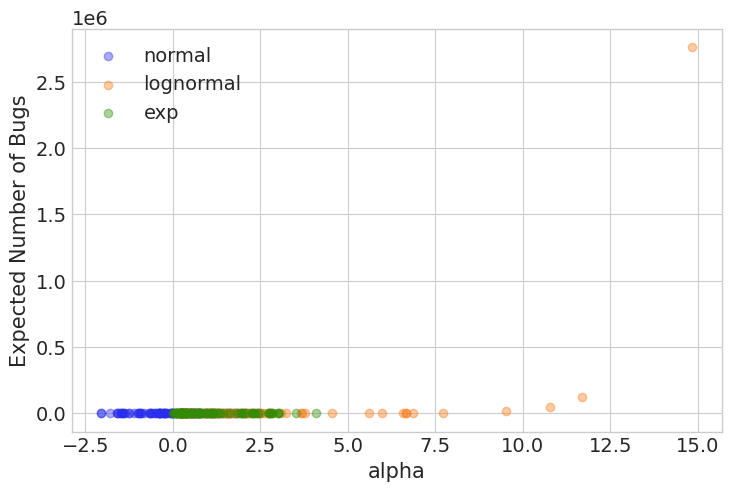

In [255]:
# First Initial Check
n_draws = np.random.normal(0, 1, 100)
ln_draws = np.random.lognormal(0,1,100)
exp_draws = np.random.exponential(1, 100)

plt.scatter(n_draws,np.exp(n_draws),label="normal", alpha=0.4)
plt.scatter(ln_draws,np.exp(ln_draws),label="lognormal", alpha=0.4)
plt.scatter(exp_draws,np.exp(exp_draws), label="exp",alpha=0.4)
plt.xlabel("alpha")
plt.ylabel("Expected Number of Bugs")
plt.legend()
plt.show()

From the plot above, it is already clear that the lognormal distribution yields exploding values for the number of bugs on average.

We can also see, that the normal distribution yields (as expected) a bunch of negative $\alpha$ values, that results in the average number of bugs to be very close to $0$. The exponential distribution's heavy tailed characteristic shows from this initialisation a greater tendency than the standard normal $N (0,1)$ to yield exploding values. 

Next we run the prior predictive checks comparing the normal and exponential distribution to find a good informative prior. This is done by fixing the normal prior $\mu=0$ and varying $\sigma$, as well as varying the rate $\lambda$ for the $Exp(\lambda)$

In [256]:
def prior_predictive_check_alpha_normal(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

def prior_predictive_check_alpha_exp(alpha_lambda_prior):
    with pm.Model() as model:
        alpha = pm.Exponential("alpha", alpha_lambda_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

Sampling: [alpha]
Sampling: [alpha]


Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


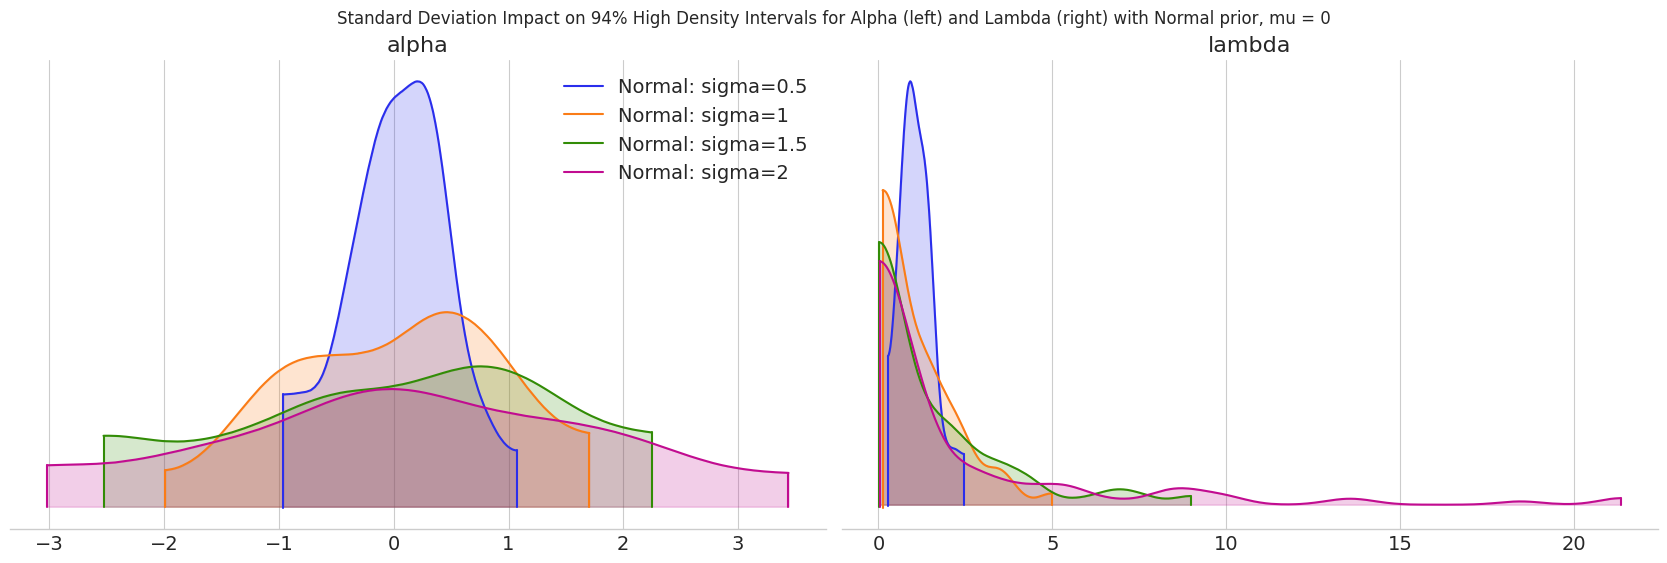

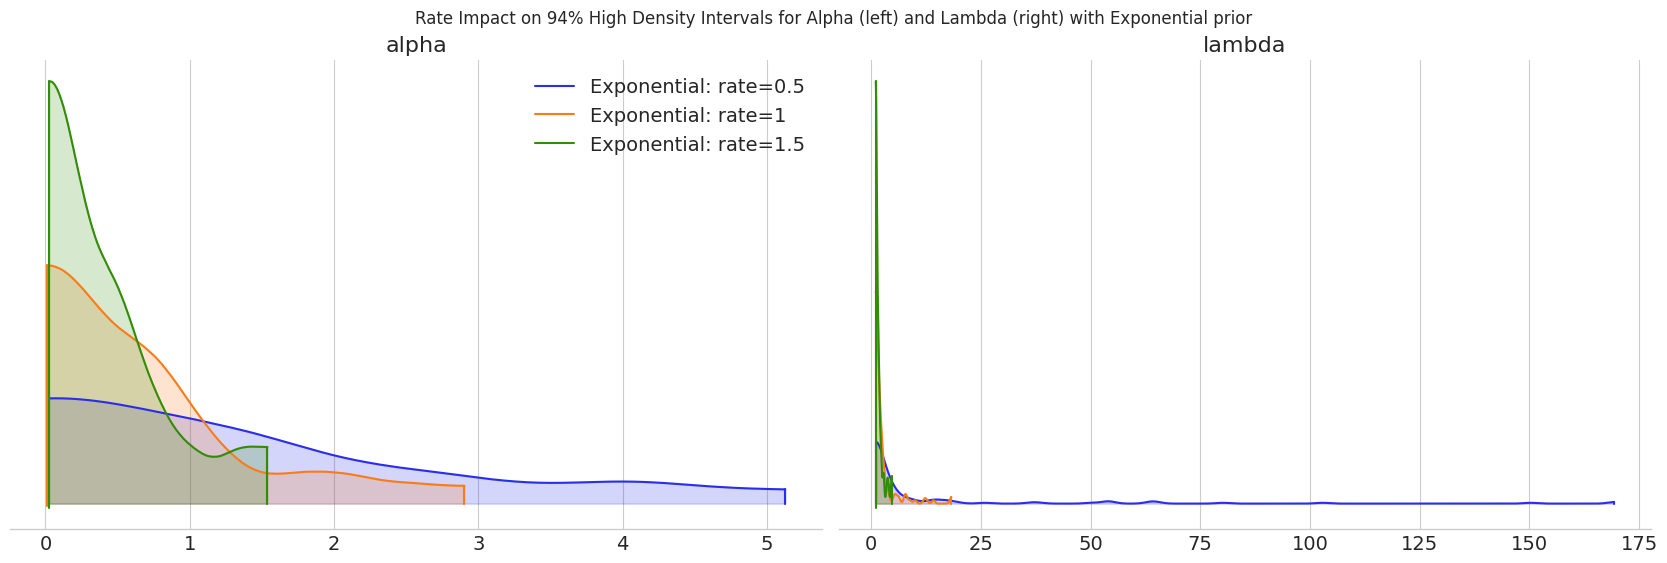

In [258]:
# Fixed Mu, varying sigmas
# Varying rate/lambda parameters
mu = 0
n_sigmas = [0.5, 1, 1.5, 2]
exp_lambdas = [0.5, 1, 1.5]


normal_traces, exponential_traces = [], []
normal_labels, exponential_labels = [], []


for sigma in n_sigmas:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    normal_traces.append(trace.prior)
    normal_labels.append(f"Normal: sigma={sigma}")

for exp in exp_lambdas:
    trace, model = prior_predictive_check_alpha_exp(exp)
    exponential_traces.append(trace.prior)
    exponential_labels.append(f"Exponential: rate={exp}")

axes = az.plot_density(
    normal_traces,
    data_labels=normal_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Standard Deviation Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, mu = 0")

axes = az.plot_density(
    exponential_traces,
    data_labels=exponential_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Rate Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Exponential prior")

plt.show()


* Based on the above KDE plots and prior predictive checks for Normal distribution with varying $\sigma$ and fixed $\mu=0$ and an exponential distribution with varying rates, it is clear that small changes in the rate $\lambda$ parameter of an exponential distribution is overly sensitive to changes in terms of pushing expected number of bugs too close to $0$ or stretches it too far out, as it is seen with $\lambda = 0.5$. The normal distribution seem to be more a suitable choice of priors for the $\alpha$, although even with a $\sigma=2$ the simulated number of bugs gets a very heavy tail. Now to find the best prior, we fix the standard deviation of 1.5, and try to rid the models from most of the negative values by increasing the $\mu$ parameter.

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


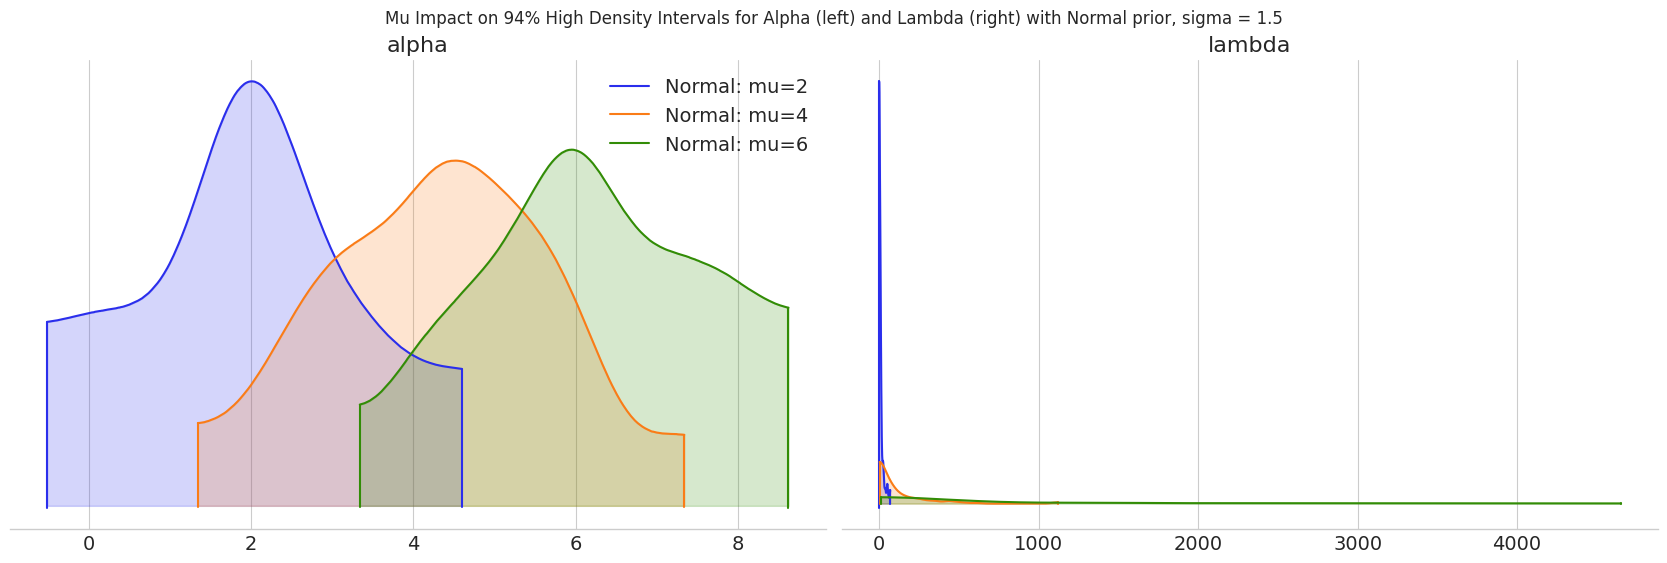

In [259]:
#Fixed Sigma, varying mu
sigma = 1.5
n_mus = [2,4,6]

traces, labels = [], []

for mu in n_mus:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    traces.append(trace.prior)
    labels.append(f"Normal: mu={mu}")

axes = az.plot_density(
    traces,
    data_labels=labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Mu Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, sigma = 1.5")
plt.show()

Based on the varying means in the prior predictive sampling for the parameter $\alpha$ and its influence on the outcome being the expected count of bugs denoted by $\lambda$. From these observations we set the prior for $\alpha_L \sim N(6, 1.5)$. As highlighted below, the probability mass of $\lambda_i$ lies within the range of $[0,\approx 5000)$. This is alot more than our own personal projects have had of commits and bugs, but these have also been tiny projects, and therefore not representative of what we expect from the population of code projects.

Sampling: [alpha]


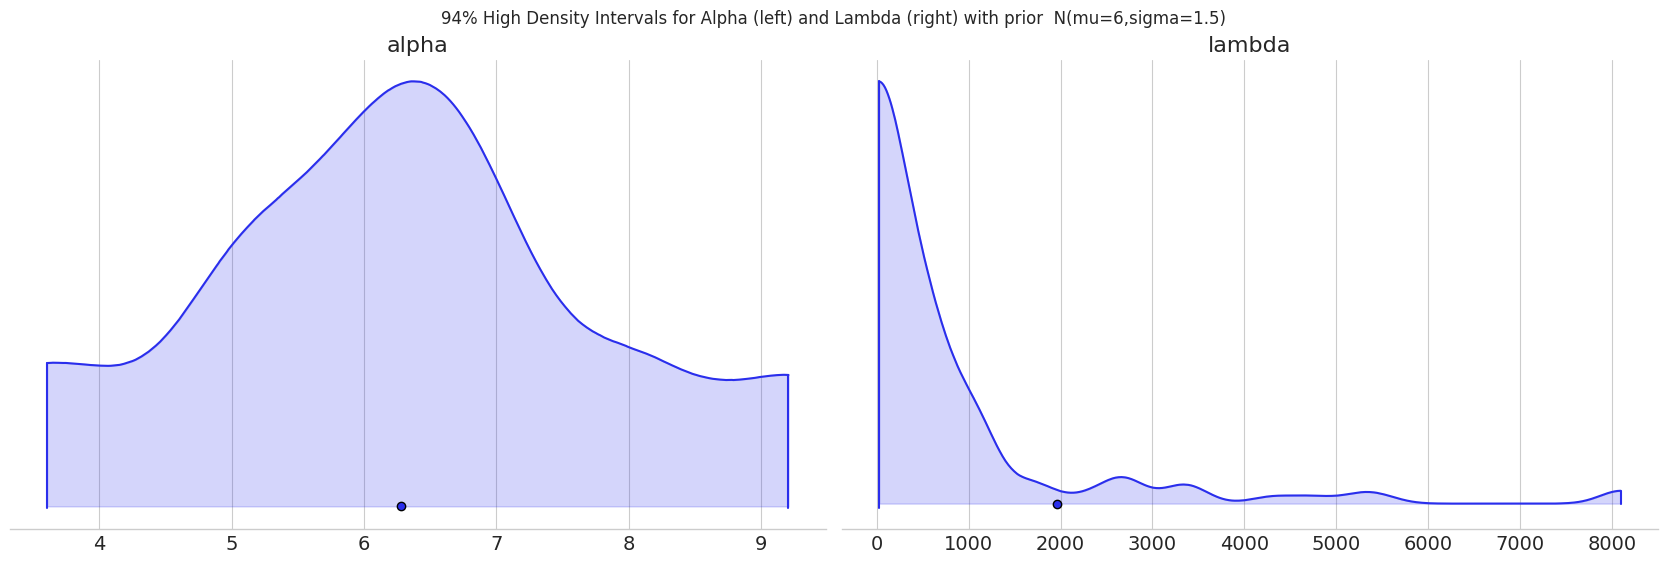

In [261]:
axes = az.plot_density(
    [prior_predictive_check_alpha_normal(6, 1.5)[0].prior],
    data_labels=["Prior Alpha selection = mu=4, sigma=1.5"],
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate="mean",
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals for Alpha (left) and Lambda (right) with prior  N(mu=6,sigma=1.5)")
plt.show()

### Model Fitting

We model the expected number of bugs as follows:

$$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha_L \\
\alpha_L \sim N(6,1.5)$$

In [262]:
## Poisson Modeling
with pm.Model() as h1_poisson_model:

      #Data
      language = pm.Data("language", df.language, mutable=True)
      # Priors
      alpha = pm.Normal("alpha", mu=6, sigma=1.5, shape=len(languages))

      #f(theta, x)
      lam= pm.Deterministic('lambda', pm.math.exp(alpha[language]))

      #likelihood
      B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
      h1_poisson_trace = pm.sample(2000, tune=2000,idata_kwargs={'log_likelihood': True}, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


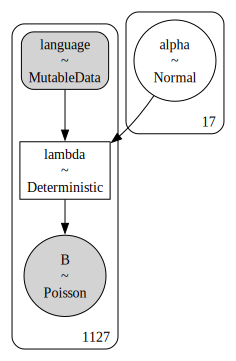

In [263]:
pm.model_to_graphviz(model=h1_poisson_model)

Below is the trace convergence for the parameter $\alpha_L$.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

As seen in the table below, the Monte Carlo Standard Error mean `mcse_mean` is $0$ for all parameters. These indicate effective sampling of the mode of the posterior distributions in all 4 chains, whilst the equivalent entries in `mcse_sd` show the chains could sample from the mode effectively without deviation. This is also shown by the high number of `ess_bulk` and `ess_tail` indicating that new samples provided new information about the posterior distribution.

In addition, all the `rhat` values are $1.0$ which means the 4 chains converged. This is also reflected in the trace plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for the poisson regression is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [265]:
az.summary(h1_poisson_trace, var_names=["alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],4.79,0.01,4.76,4.81,0.0,0.0,14765.07,6291.84,1.0
alpha[1],5.26,0.00,5.25,5.27,0.0,0.0,13824.28,5671.44,1.0
alpha[2],4.83,0.01,4.81,4.85,0.0,0.0,12745.51,5197.36,1.0
alpha[3],6.16,0.01,6.15,6.17,0.0,0.0,13721.30,5476.10,1.0
alpha[4],6.72,0.00,6.71,6.73,0.0,0.0,15553.63,5151.78,1.0
alpha[5],6.90,0.00,6.89,6.91,0.0,0.0,14910.05,5656.82,1.0
alpha[6],4.28,0.02,4.23,4.32,0.0,0.0,15164.81,5984.75,1.0
alpha[7],7.71,0.00,7.70,7.71,0.0,0.0,13340.83,6053.13,1.0
alpha[8],6.83,0.00,6.82,6.83,0.0,0.0,13382.82,5917.33,1.0
alpha[9],5.26,0.01,5.24,5.29,0.0,0.0,14642.66,5886.22,1.0


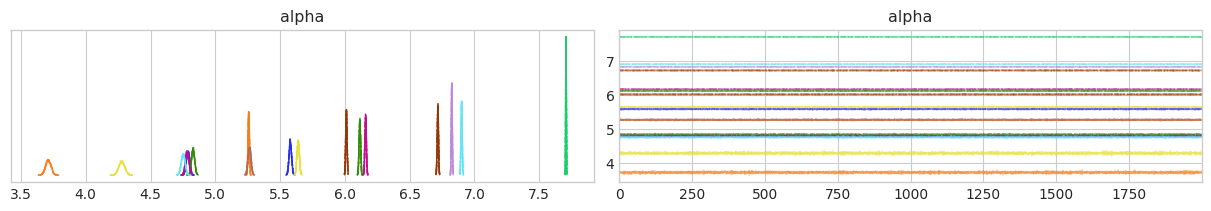

In [266]:
pm.plot_trace(h1_poisson_trace, var_names=['alpha']);

Below is a forest plot and a numerical representation of the means and standard deviations (sd) from the posterior distributions of $\alpha_L$. The posterior estimates estimates of the $\alpha_L$ means, have moved away from the prior mean of $6$ while also reducing their estimated standard deviations from $1.5$ to $\approx 0.01$. This shows that the expected number of bugs was overestimated by the prior for some languages while for others it was underestimated. 

We see notable differences in the effect between languages on the expected number of bugs. For example that `C` is estimated to have the highest number of bugs while `Typescript` is estimated to have the least amount of expected bugs.

In [273]:
#Nummerical summary alpha
summary_alpha_poisson = pm.summary(h1_poisson_trace, var_names=['alpha'],round_to=4)[['mean', 'sd']].reset_index(names="parameter")
summary_alpha_poisson
summary_alpha_poisson["language"] = languages.take(summary_alpha_poisson.index)
summary_alpha_poisson

,parameter,mean,sd,language
0,alpha[0],4.7896,0.0131,Clojure
1,alpha[1],5.2579,0.0050,Javascript
2,alpha[2],4.8284,0.0119,Objective-C
3,alpha[3],6.1601,0.0053,Java
4,alpha[4],6.7174,0.0046,Php
5,alpha[5],6.9008,0.0044,C#
6,alpha[6],4.2781,0.0235,Perl
7,alpha[7],7.7069,0.0023,C
8,alpha[8],6.8251,0.0035,C++
9,alpha[9],5.2641,0.0113,Erlang


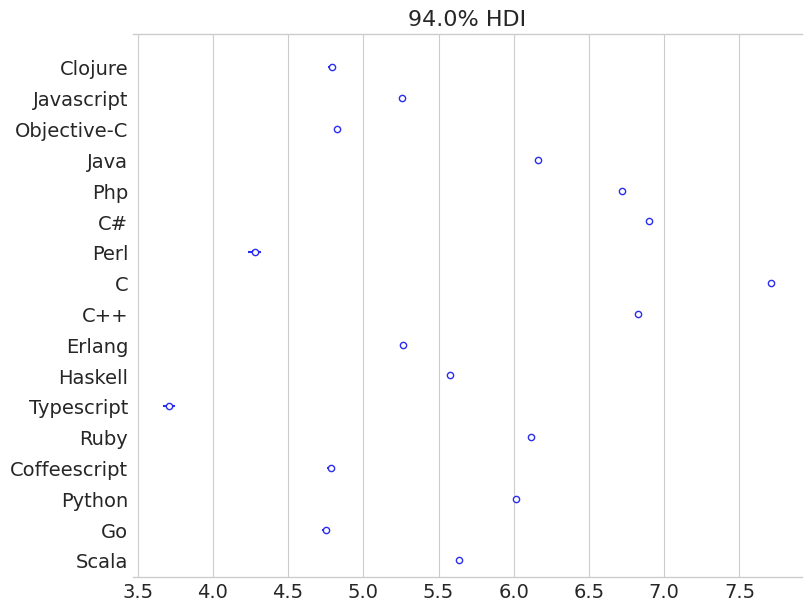

In [274]:
_,ax = plt.subplots(figsize=(8,6))
az.plot_forest(h1_poisson_trace, var_names=["alpha"], combined=True, figsize=(10, 5), ax=ax)
forest_languages = [int(i.get_text()[1:-1]) if len(i.get_text()) < 6 else 0 for i in ax.get_yticklabels()]
ax.set_yticklabels(languages.take(forest_languages)); 

### Posterior Predictive Check

In [286]:
pareto_k_h1 = az.loo(h1_poisson_trace, pointwise=True).pareto_k.values
print("Max PSIS value for alpha_language: ", max(pareto_k_h1))

Max PSIS value for alpha_language:  66.56261309123396


We get the following warning: 

*"Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations"*

This warning indicates that some projects are highly influential on the model, and that taking them out at random, changes the posterior distribution.

We sample $1127$ entries with randomly assigned languages and use those for posterior predictions:

In [295]:
n_points = len(df)
x_seq = np.random.randint(size=n_points, low=0, high=len(languages))

with h1_poisson_model:
    pm.set_data({"language": x_seq})
    post_pred_h1 = pm.sample_posterior_predictive(h1_poisson_trace, var_names=['B'])['posterior_predictive']['B']
    
post_pred_h1_mean = post_pred_h1.mean(["chain", "draw"])

Sampling: [B]


To investigate the posterior predictions and the highly influential datapoints, below is plotted the `h1_poisson_model` mean prediction and 95% HDI as well as the individual observations for each datapoint. Each entry in the plot is sized by its pareto smooth importance value. 

It is clear from the plot, that some projects like `Linux` written in `C` has more bugs than twice the order of magnitude of the other projects. This is also denoted by the red circle and its value of 1, that originally was (as seen above) $66.56$. The other projects relative `PSIS` values have equally been normalized, and required a scaling in size of $3000$, to be used for the plot below. This indicates that some projects in combination with some languages have a great outlying number of bugs compared to the average estimation.

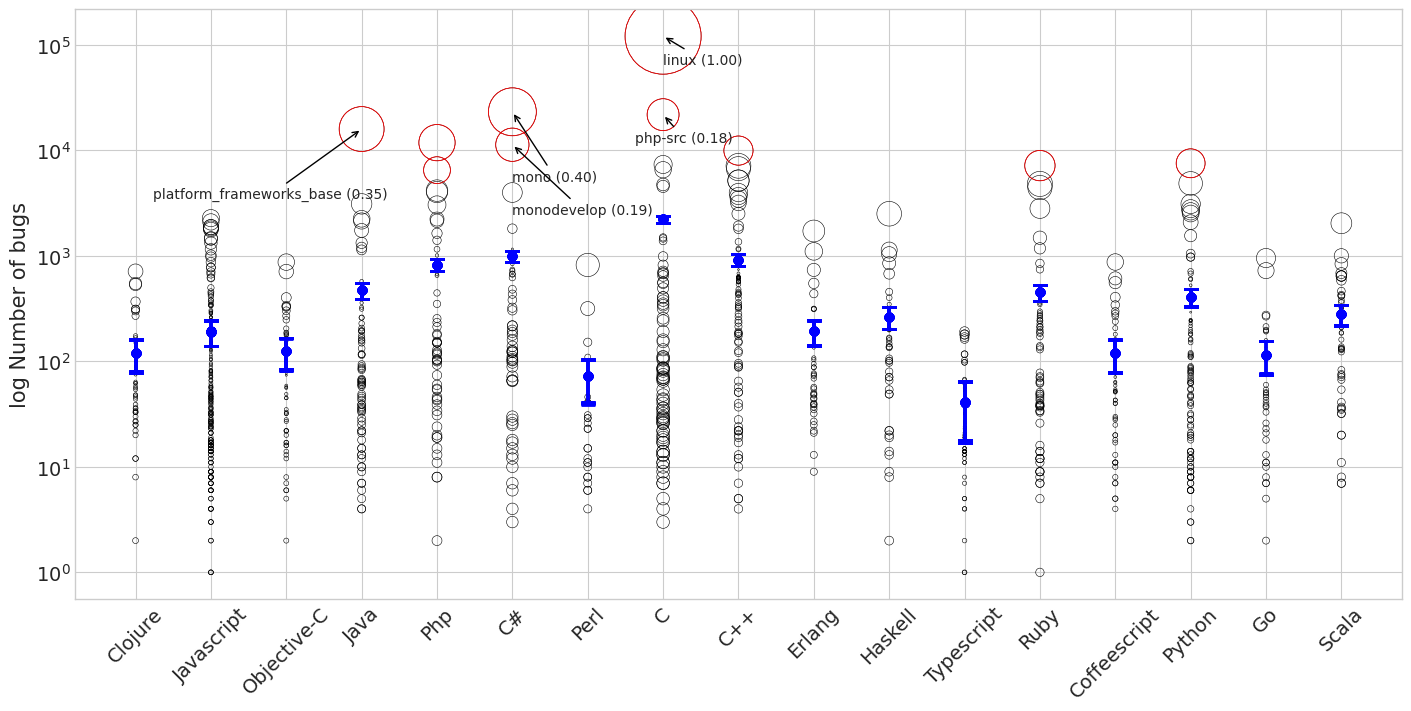

In [296]:
#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h1 /= pareto_k_h1.max()
pareto_k_h1_size = 3000 * pareto_k_h1

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h1)[-10:][::-1]
top_data_points = df.iloc[top_indices]

#compute error bars of 95 HDI
hdi = az.hdi(post_pred_h1)
lower_bound, upper_bound = hdi.data_vars["B"].to_numpy()[:,0], hdi.data_vars["B"].to_numpy()[:,1]
diffs = upper_bound - lower_bound  

fig, axes = plt.subplots(figsize=(14,7))
axes.set_yscale("log")

axes.errorbar(x_seq, post_pred_h1_mean, yerr=diffs, fmt='o', color='b', ecolor='b', capsize=5, capthick=2)
axes.scatter(df.language, df.bugs, s = pareto_k_h1_size, facecolors='none', edgecolors='k', lw=0.4)
axes.scatter(top_data_points.language, top_data_points.bugs, s = pareto_k_h1_size[top_indices], facecolors='none', edgecolors='r', lw=0.6)
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
axes.set_ylabel("log Number of bugs")
axes.set_xticks(ticks=ticks)
axes.set_xticklabels(labels=languages, rotation=45)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    # print(row)
    dont_annotate = False
    if row['language'] == 7 and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 1:
        position=(-70,15)
    elif row['language'] == 5:
        position=(0,-50)
    elif row['language'] == 7 and row['project'] == 'php-src':
        position=(-20,-20)
    elif row["language"] == 3:
        position = (-150,-50)
    else:
        dont_annotate = True
    if dont_annotate == False:
        axes.annotate(f"{row['project']} ({pareto_k_h1[index]:.2f})", xy=(row['language'], row['bugs']), xytext=position,textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.show()


As seen above, the 10 projects with the greatest `PSIS` values, have been plotted in red. Below is the same plot but without these 10 influential datapoints and on a linear scale.

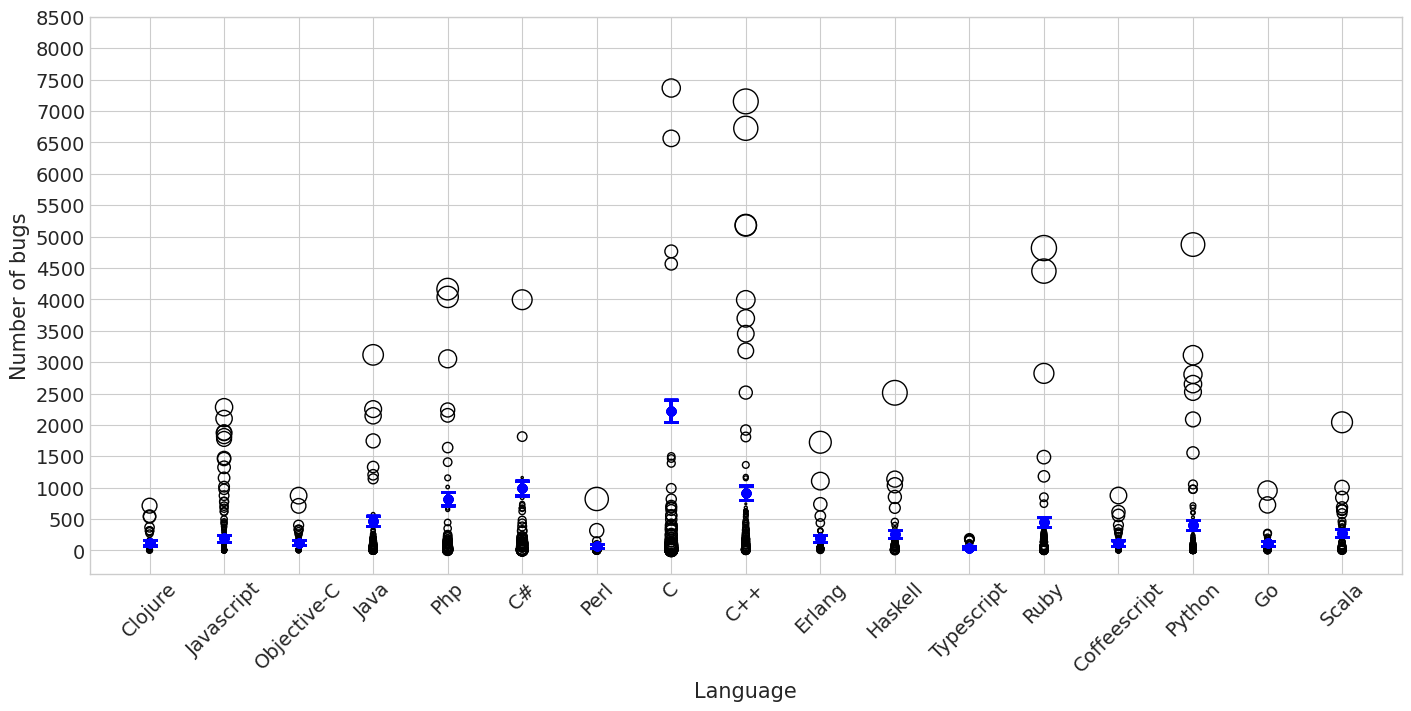

In [288]:
fig,axes = plt.subplots(figsize=(14,7))

pareto_k_size_without_top = np.delete(pareto_k_h1_size, top_indices)
df_without_top = df.drop(top_indices)

axes.errorbar(x_seq, post_pred_h1_mean, yerr=diffs, fmt='o', color='b', ecolor='b', capsize=5, capthick=2)
axes.scatter(df_without_top.language, df_without_top.bugs, facecolors='none', s=pareto_k_size_without_top, edgecolors='k', lw=1)
axes.set_xlabel('Language')
axes.set_ylabel('Number of bugs')
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
axes.set_xticks(ticks=ticks)
axes.set_xticklabels(labels=languages, rotation=45)
plt.yticks(np.arange(0, 9000, 500));

From the plotted mean prediction and $95\%$ HDI interval of `h1_poisson_model`, most of the languages have an expected number of bugs somewhere between $0$ and $1000$. An outlier is the prediction for `C` which has a mean of $2224$ bugs.


From the plot it is not clear which of the posterior distributions of $\lambda_L$ is the smallest. Specifically we are interested in whether programming in Haskell yields the smallest probability to bugs given the model parameters and the data. 
To explore this, we look at the numerical estimates of the posterior $\lambda_L$ means.
Secondly, we plot the Kernel Density Estimates from each of the top $5$ $\lambda_L$ posterior distributions that yields the highest probability to the smallest number of bugs. This plot is also extended with the Haskell Kernel Density Estimate for comparison.

Sampling: []


Numerically ranked languages by expected number of bugs:
 
         lambdas      language
0     40.908209    Typescript
1     72.126190          Perl
2    115.875947            Go
3    119.435914  Coffeescript
4    120.261046       Clojure
5    125.015576   Objective-C
6    192.084680    Javascript
7    193.289955        Erlang
8    264.815164       Haskell
9    281.215820         Scala
10   408.178823        Python
11   452.852243          Ruby
12   473.460662          Java
13   826.702537           Php
14   920.636941           C++
15   993.049003            C#
16  2223.701854             C


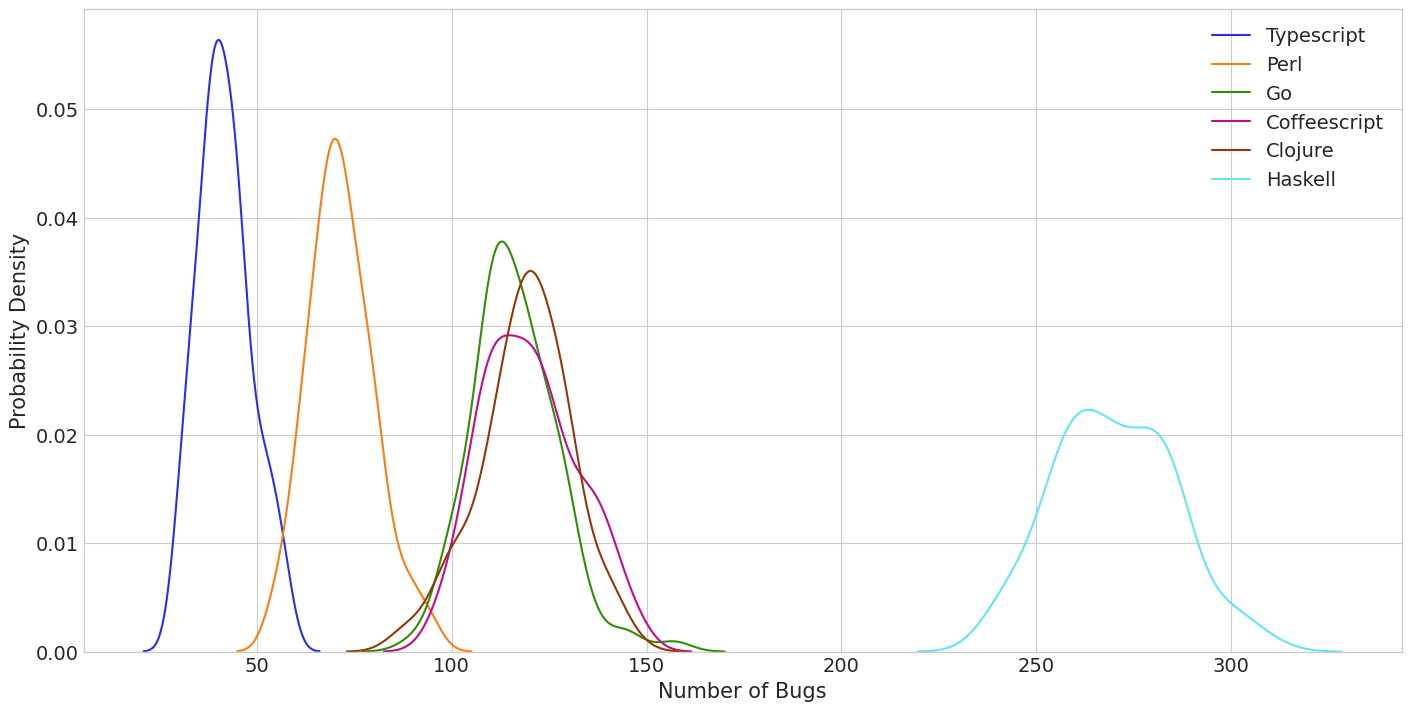

In [323]:
n_points = len(df)
x_seq = np.array(range(len(languages)))

with h1_poisson_model:
    pm.set_data({"language": x_seq})
    post_pred_h1_plot = pm.sample_posterior_predictive(h1_poisson_trace, var_names=['lambda'])['posterior_predictive']['lambda']
    
post_pred_h1_mean_plot = post_pred_h1_plot.mean(["chain", "draw"])

seaborn_plot_data = pd.DataFrame({"lambdas": post_pred_h1_mean_plot, "language": languages})
seaborn_plot_data.sort_values("lambdas", ascending=True, inplace=True)
print("Numerically ranked languages by expected number of bugs:\n \n" , seaborn_plot_data.reset_index(drop=True))
_, axes = plt.subplots(figsize=(14, 7))

#Generating Poisson data
for language, expected_count in zip(seaborn_plot_data["language"].to_list()[:5], seaborn_plot_data["lambdas"].to_list()[:5]):
    sample = poisson.rvs(mu=expected_count, size=100)
    sns.kdeplot(x=sample, fill=False, label=f'{language}', ax=axes)

sample = poisson.rvs(seaborn_plot_data[seaborn_plot_data["language"]=="Haskell"]["lambdas"], size=100)
sns.kdeplot(x=sample, fill=False, label="Haskell", ax=axes)

axes.set_xlabel('Number of Bugs')
axes.set_ylabel('Probability Density')
plt.legend()
plt.show();

#### Part Conclusion H1

Based on the above results, we can see that Haskell is not in the top 5 languages with lowest number of expected bugs. Based on these results we reject H1. The programming language that would fulfill that hypothesis based on `h1_poisson_model` would be Typescript with its $\lambda = 41$ i.e. the expected bugs for an average project. This is also seen from the posterior mean of $\alpha_{typescript} = 3.7111$ which is the smallest value for $\alpha_L$.

### Can we model this in any other way?

As of now we have only modelled the probability of the least amount of bugs among all programming languages with `h1_poisson_model` to which H1 is rejected. The danger of a GLM poisson regression with this dataset is that if a certain language is used in larger projects in terms of commits, the model will pick up on some misleading relationships between languages and the number of bugs, simply because the language has been used in projects with many bugs. This hypothesis could also be modelled by a **binomial regression**, where the probability $p$ of a success - a bug - is modelled by $k$ number of successes (*bugs*) in $N$ number of bernoulli trials (*Commits*).

Now follows the same procedure as above, to see whether using a binomial regression changes our conclusion to **H1**.

## Binomial Regression

The model includes an $\alpha_L$ to see the average effect of a language on the probability of a bug.

\begin{align*}
B_i \sim & \; \mathrm{Binomial}(N_i, p_i)\\
\mathrm{logit}(p_i) = & \; \alpha_{L}\\
\alpha_L \sim & \; \text{Not yet Determined} \\
\end{align*}



We took inspiration for prior predictive checks from lecture $09$.
Here it is important to stress, that the probability mass for the outcome variable $p_i$ has to be as evenly distributed between $(0,1)$, such that the prior assumption is neither only successes or only failures for each independent bernoulli trial of commits.

### Prior Predictive Checks

Using the inspiration from lecture 9, we show the prior assumptions from two Normal priors with for $\alpha$ one standard normal $N(\mu=0,\sigma=2)$ and one with a larger value for $\sigma=5$

In [310]:
with pm.Model() as standard_binomial_prior:

    alpha = pm.Normal("alpha", mu=0, sigma=2)
    p = pm.Deterministic("p", pm.math.invlogit(alpha))
    y_i = pm.Binomial("y", n=1, p=p, observed=df.bugs)



with pm.Model() as sigma_binomial_prior:

    alpha = pm.Normal("alpha", mu=0, sigma=5)
    p = pm.Deterministic("p", pm.math.invlogit(alpha))
    y_i = pm.Binomial("y", n=1, p=p, observed=df.bugs)

prior_standard  = pm.sample_prior_predictive(model=standard_binomial_prior).prior
prior_sigma = pm.sample_prior_predictive(model=sigma_binomial_prior).prior

Sampling: [alpha, y]


Sampling: [alpha, y]


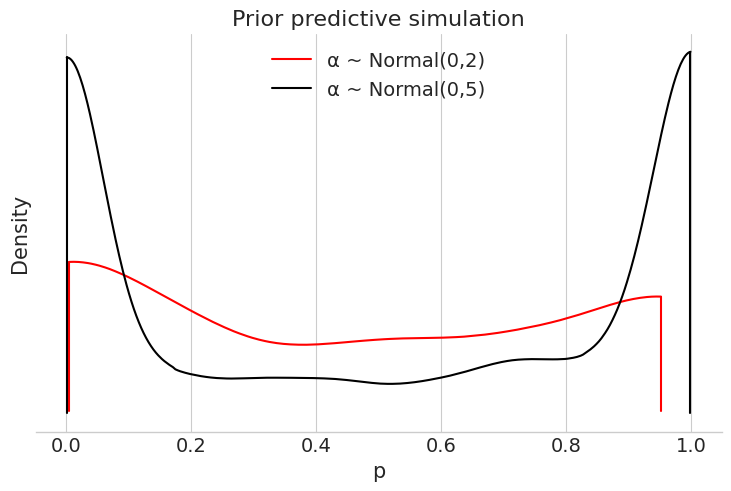

In [313]:
az.plot_density(
    [prior_standard["p"], prior_sigma["p"]],
    data_labels=['α ~ Normal(0,2)','α ~ Normal(0,5)'],
    colors=['red','black'],point_estimate=None)
plt.title('Prior predictive simulation')
plt.xlabel('p')
plt.ylabel('Density');

We will chose the following prior for $\alpha_L$

$$\alpha_L \sim N(0,2)$$



### Model Fitting

\begin{align*}
B_i \sim & \; \mathrm{Binomial}(N_i, p_i)\\
\mathrm{logit}(p_i) = & \; \alpha_{L}\\
\alpha_L \sim & \; N(0,2) \\
\end{align*}


In [314]:
with pm.Model() as h1_binomial_model:
      #Data
      language = pm.Data("language", df.language, mutable=True)
      
      # Priors
      alpha = pm.Normal("alpha", mu=0, sigma=2, shape=len(languages))
      
      #f(theta , x)
      p = pm.Deterministic("p", pm.math.invlogit(alpha[language]))

      # likelihood
      y_i = pm.Binomial("y", n=df.commits, p=p, observed=df.bugs)
      h1_binomial_trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


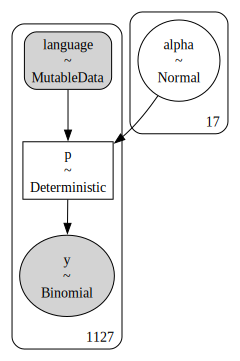

In [315]:
pm.model_to_graphviz(model=h1_binomial_model)

The trace summary looks valid in estimating the posterior distributions of the probability of a bug for a given datapoint, since the `r_hat` for all parameters are $1.0$. Additionally the `mcse_mean` and `mcse_sd` indicate that both samplings from the mode of the posterior could be done successfully. 

In [316]:
pm.summary(h1_binomial_trace, var_names=["alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.31,0.01,-1.34,-1.28,0.0,0.0,13846.33,5713.56,1.0
alpha[1],-0.69,0.01,-0.70,-0.68,0.0,0.0,15760.83,5933.85,1.0
alpha[2],-0.72,0.01,-0.74,-0.69,0.0,0.0,14428.53,5710.26,1.0
alpha[3],-0.39,0.01,-0.40,-0.37,0.0,0.0,15495.09,5698.10,1.0
alpha[4],-0.41,0.01,-0.42,-0.40,0.0,0.0,14602.94,5523.36,1.0
alpha[5],-0.52,0.01,-0.53,-0.51,0.0,0.0,16685.33,5888.34,1.0
alpha[6],-0.58,0.03,-0.63,-0.52,0.0,0.0,15550.13,6228.66,1.0
alpha[7],-0.37,0.00,-0.38,-0.37,0.0,0.0,16336.66,6288.19,1.0
alpha[8],-0.39,0.00,-0.40,-0.38,0.0,0.0,17145.30,6062.68,1.0
alpha[9],-1.05,0.01,-1.07,-1.03,0.0,0.0,14410.36,6234.72,1.0


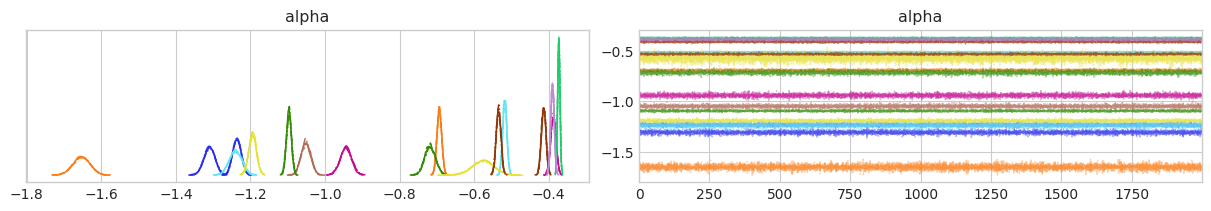

In [317]:
pm.plot_trace(h1_binomial_trace, var_names=['alpha']);

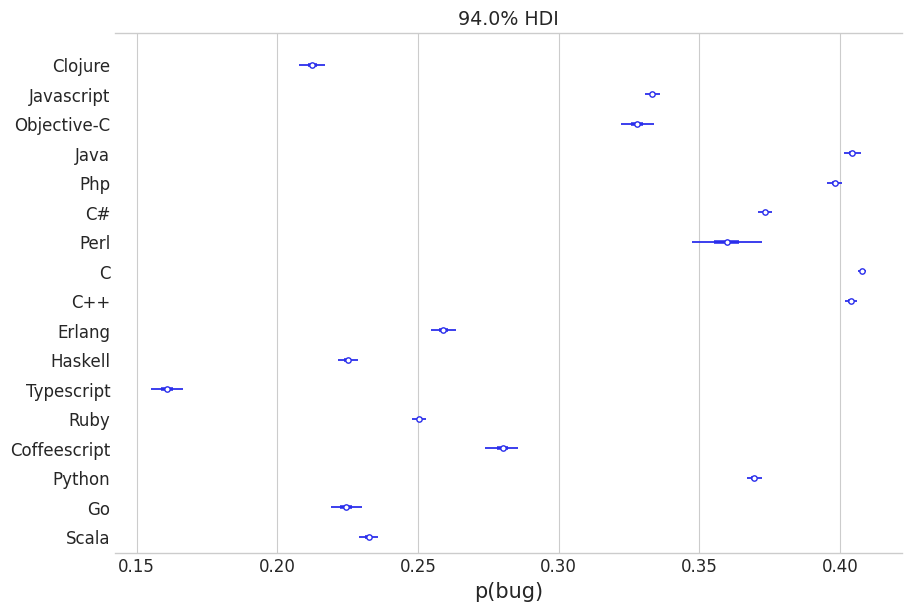

In [318]:
_, ax = plt.subplots(figsize=(9,6))
az.plot_forest(h1_binomial_trace, var_names=["alpha"], ax=ax, combined=True,legend=True, textsize=12.0, transform=expit);
forest_languages = [int(i.get_text()[1:-1]) if len(i.get_text()) < 6 else 0 for i in ax.get_yticklabels()]
ax.set_xlabel("p(bug)"); 
ax.set_yticklabels(languages.take(forest_languages)); 

Based on the above forest plot, the `h1_binomial_model` shows similar results to `h1_poisson_model`. In particular we see that the language `C` has the highest estimated probability of a bug. Similarly, `Typescript` has the smallest estimated probability of bug, which aligns with the results of `h1_poisson_model`. Contrary to the poisson regression where ´Haskell´ was the 9th ranked language in terms of least number of bugs. It has now moved to being the language with the 4'th least probability of a bug.

#### Conclusion H1

Based on the results from `h1_poisson_model` and `h1_binomial_model`, we reject H1. `Haskell` does **neither** give the highest probability to the lowest number of bugs **nor** does it give the smallest probability to a bug given a commit. This means that `Haskell` is not less prone to containing bugs than any other languages based on our results. It was in fact `Typescript` that gave the highest probability to the lowest number of bugs.